# **CMPE 256 - Project**

## **Spotify Song Recommendation System**




This project is a prototype of Spotify Song Classification and Recommendation system that can classify the Songs Genre labels and can recommend a set of songs to the user given the user's playlist of songs and user's ratings to those songs.
<br><br>
To run this project, 'songs.csv' file is required which contains the dependent dataset in it.

### Importing Libraries and Dataset

This project is developed using multiple modules present in various Python libraries.
<br><br>
The dataset used in this project is Spotify songs dataset which has around 100,000 records in it.

In [3]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, io
import math
import operator

from random import randint
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, normalize, StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, mean_squared_error, silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns; sns.set(style='white')
pd.options.mode.chained_assignment = None 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
# Loading the songs dataset from CSV file into a dataframe

df = pd.read_csv('songs.csv', low_memory=False)

# Data Preprocessing

In [5]:
# Displaying the first 5 records in the dataframe

df.head()

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Type,ID,Uri,Ref_Track,URL_features,Duration_ms,time_signature,Genre
0,YuveYuveYu,0.624,0.857,10.0,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926,audio_features,6J2VvzKwWc2f0JP5RQVZjq,spotify:track:6J2VvzKwWc2f0JP5RQVZjq,https://api.spotify.com/v1/tracks/6J2VvzKwWc2f...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal
1,Gloryhammer,0.517,0.916,0.0,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996,audio_features,4HA34COgxgVJ6zK88UN4Ik,spotify:track:4HA34COgxgVJ6zK88UN4Ik,https://api.spotify.com/v1/tracks/4HA34COgxgVJ...,https://api.spotify.com/v1/audio-analysis/4HA3...,300320.0,4.0,celticmetal
2,Nostos,0.251,0.894,8.0,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223,audio_features,3W6Xik6Xxf06JuUoZSATlD,spotify:track:3W6Xik6Xxf06JuUoZSATlD,https://api.spotify.com/v1/tracks/3W6Xik6Xxf06...,https://api.spotify.com/v1/audio-analysis/3W6X...,175353.0,4.0,celticmetal
3,Yggdrasil,0.469,0.743,1.0,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953,audio_features,2gGveBaLJQMtJ43X4UL5kH,spotify:track:2gGveBaLJQMtJ43X4UL5kH,https://api.spotify.com/v1/tracks/2gGveBaLJQMt...,https://api.spotify.com/v1/audio-analysis/2gGv...,272292.0,4.0,celticmetal
4,Incense&Iron,0.487,0.952,1.0,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993,audio_features,1lRF81A1C9QoCgBcEop2zg,spotify:track:1lRF81A1C9QoCgBcEop2zg,https://api.spotify.com/v1/tracks/1lRF81A1C9Qo...,https://api.spotify.com/v1/audio-analysis/1lRF...,237933.0,4.0,celticmetal


The above table shows the different columns present in the dataset and their data types initially.

In [6]:
# Displaying the descriptions and distribution of all the numerical columns in the dataframe

df.describe()

,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Duration_ms
count,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,131580.000000,1.315800e+05
mean,0.553784,0.648783,5.311356,-8.523482,0.618985,0.083736,0.270991,0.231870,0.193345,0.493751,2.536664e+05
std,0.182683,0.255634,3.570006,4.789160,0.485626,0.101581,0.323490,0.353740,0.162596,1.799546,1.256204e+05
min,0.000000,0.000000,-14.372000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+00
25%,0.432000,0.487000,2.000000,-10.377000,0.000000,0.035900,0.007930,0.000002,0.095100,0.247000,1.909330e+05
50%,0.566000,0.690000,5.000000,-7.377000,1.000000,0.048300,0.105000,0.001480,0.125000,0.459000,2.290000e+05
75%,0.692000,0.853000,9.000000,-5.344000,1.000000,0.083000,0.487000,0.503000,0.246000,0.683000,2.854792e+05
max,0.988000,11.000000,11.000000,5.056000,1.000000,0.966000,0.996000,0.999000,1.000000,187.827000,5.949886e+06


It is required to drop the duplicate records based on the Song ID. If there are multiple records with same song ID, then the recommendation and classification would not be accurate.

In [7]:
# Dropping the duplicate records which have the same Song ID

df = df.drop_duplicates(subset=['ID'], keep='first', inplace=False)

In [8]:
# Displaying the counts of fields having null values

df.isna().sum()

Name                 1
Danceability         0
Energy               0
Key                  0
Loudness             0
Mode                 0
Speechness           0
Acousticness         0
Instrumentalness     0
Liveness             0
Valence              0
Tempo                0
Type                 0
ID                   0
Uri                  0
Ref_Track            0
URL_features         0
Duration_ms          0
time_signature       0
Genre               24
dtype: int64

It is observed that all the columns have all the values except for Song name and Genre name columns. We can impute the missing values if the columns are numerical. But as the columns are categorical and are String values, they can be dropped.

In [9]:
# Dropping the records which have Null values

df = df.dropna()

There are few columns which are not significant and do not contribute to the feature vector of the songs. Hence these columns can be dropped.

In [10]:
# Dropping the columns which are not relevant and are not useful to train the model

df = df.drop(columns=['Type', 'Uri', 'Ref_Track', 'URL_features', 'time_signature', 'Duration_ms'])

The categorical values should be convert to numerical values before training any model or performing any calculations. Hence, they are encoded to numerical values using LabelEncoder module.

In [11]:
# Encoding the columns ID and Genre which are in String format into Numerical format and replacing them in the dataframe

le = LabelEncoder()
ID = le.fit_transform(df['ID'])
Genre_ID = le.fit_transform(df['Genre'])
df['ID'] = ID
df['Genre_ID'] = Genre_ID

In [12]:
# Displaying the descriptions of all the numerical columns after encoding and dropping unwanted records

df.describe()

,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,ID,Genre_ID
count,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.000000,107972.00000,107972.000000
mean,0.550961,0.642297,5.310043,-8.671982,0.617493,0.084604,0.279793,0.241156,0.194110,0.465389,53985.50000,306.211647
std,0.184471,0.249686,3.567536,4.916758,0.486002,0.102570,0.328709,0.358198,0.164054,0.267501,31168.97597,178.154912
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.427000,0.477000,2.000000,-10.570000,0.000000,0.036100,0.008138,0.000002,0.095100,0.239000,26992.75000,158.000000
50%,0.564000,0.683000,5.000000,-7.479000,1.000000,0.048500,0.114000,0.001990,0.125000,0.453000,53985.50000,314.000000
75%,0.691000,0.851000,9.000000,-5.397000,1.000000,0.083900,0.513000,0.557000,0.247000,0.681000,80978.25000,460.000000
max,0.988000,1.000000,11.000000,5.056000,1.000000,0.966000,0.996000,0.999000,1.000000,1.000000,107971.00000,611.000000


In [13]:
# Displaying the top 5 records in the dataframe

df.head()

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,ID,Genre,Genre_ID
0,YuveYuveYu,0.624,0.857,10.0,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926,87344,celticmetal,80
1,Gloryhammer,0.517,0.916,0.0,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996,59537,celticmetal,80
2,Nostos,0.251,0.894,8.0,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223,49059,celticmetal,80
3,Yggdrasil,0.469,0.743,1.0,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953,37479,celticmetal,80
4,Incense&Iron,0.487,0.952,1.0,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993,24764,celticmetal,80


In [14]:
# Displaying the count of Unique Genres in the dataframe

print("Unique Genres:", len(np.unique(df['Genre_ID'])))

Unique Genres: 612


In [15]:
# Displaying the count of Unique Songs in the dataframe

print("Unique Songs:", len(np.unique(df['ID'])))

Unique Songs: 107972


After cleaning the dataset, there are 107972 records and 612 Unique Genres.

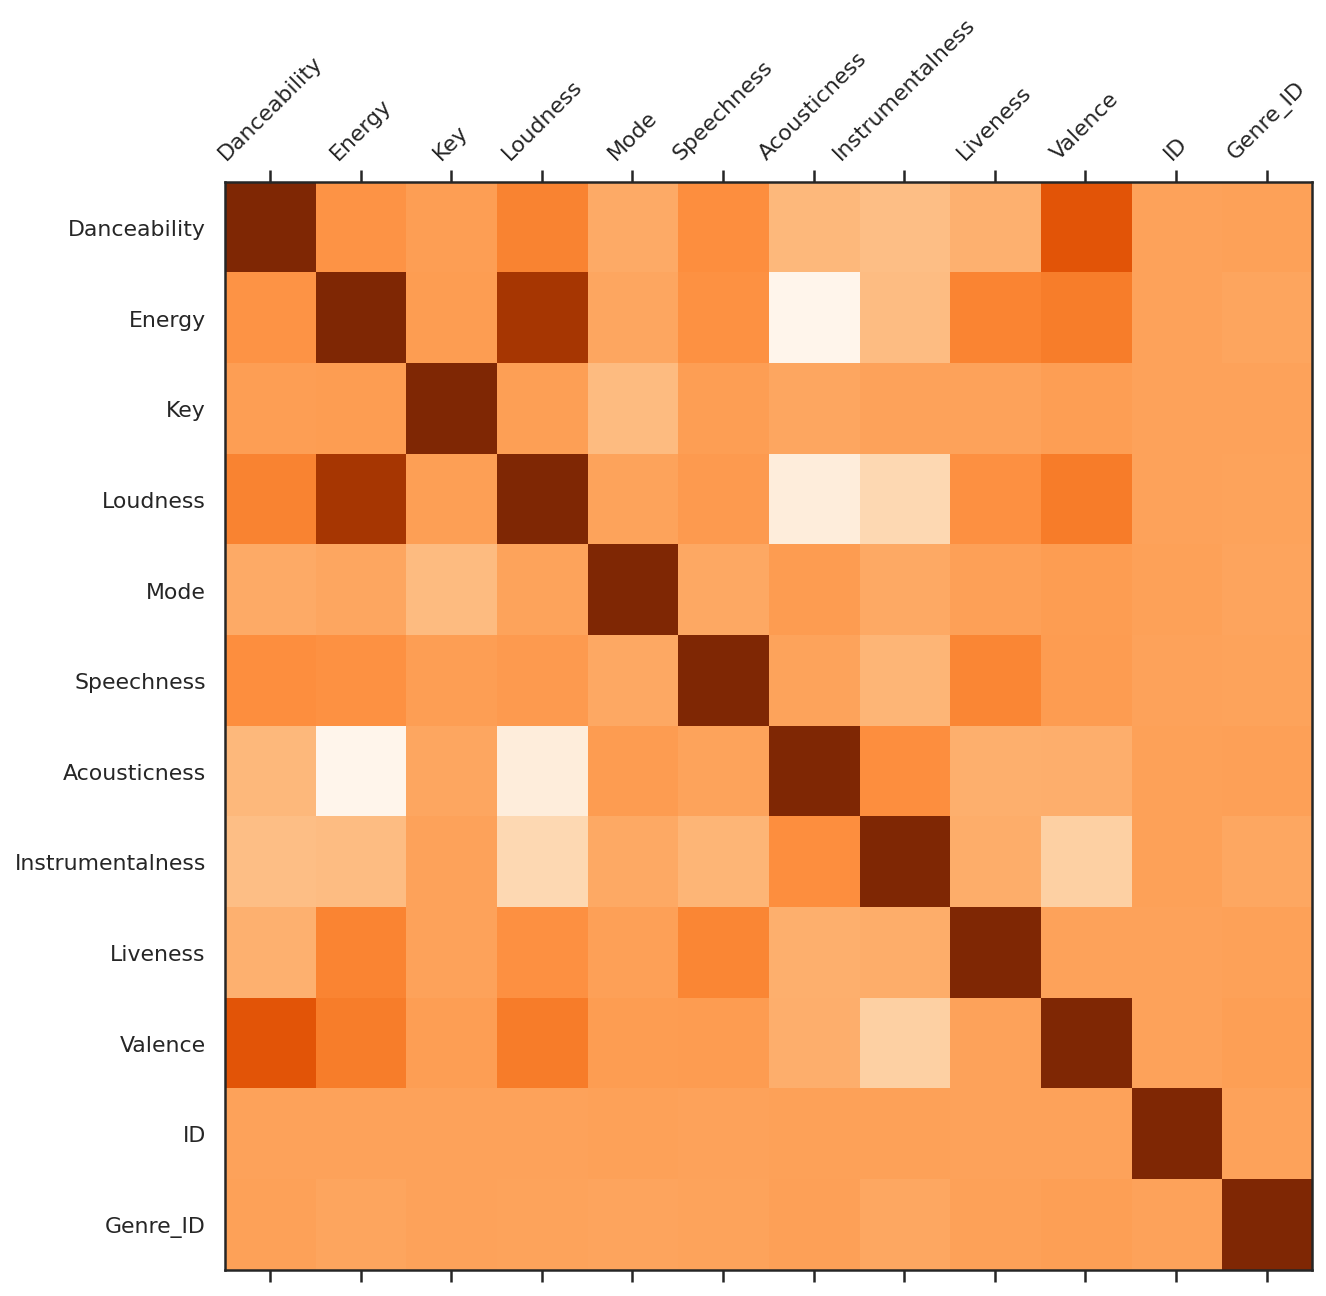

In [16]:
# Plotting the correlation heat map of columns in dataframe

# Reference: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# https://matplotlib.org/api/pyplot_api.html

def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr, cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    
plot_corr(df)

Based on the above Correlation heat map, it is clear that ID and Genre_ID are less correlated with other columns. Hence they may not be used while performing recommendation.

In [17]:
# Dropping the ID columns and string columns which are not required to train the classification model

df = df.drop(columns=['Genre'])
data = df.drop(columns=['ID', 'Genre_ID', 'Name'])

In [18]:
# Displaying the top 5 records in the dataframe after removing string columns

data.head()

,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0.624,0.857,10.0,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926
1,0.517,0.916,0.0,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996
2,0.251,0.894,8.0,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223
3,0.469,0.743,1.0,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953
4,0.487,0.952,1.0,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993


# Classification of Genre

In this project, the genre labels are classified by using a Classification Model. The classification model is initially trained with a given training dataset and then it can be used to predict the Genre for a given song.
<br><br>
For the given dataset, the dataset is split into two parts, one for training and other for validation. The training set will be used to train the classification model and validation set will be used to measure the accuracy of the trained model. The training set will be initially normalized using StandardScaler normalization then the dimensionality is reduced using PCA.
<br><br>
Multiple Classification algorithms will be used and trained with different parameters using GridSearch and the best classifier is fetched based on their score.
The classification algorithms used are:
* K Neighbors Classifier
* Random Forest Classifier
* Decision Tree Classifier

In [19]:
# Initializing the feature vector and labels to train the classification model

X = data
y = df.Genre_ID

In [20]:
# Creating a Holdout set by splitting the dataframe to predict and validate the classification model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Normalizing the training dataset by removing mean and scaling it to unit variance using StandardScaler transformation
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

stdScaler = StandardScaler()
X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled = stdScaler.fit_transform(X_test)

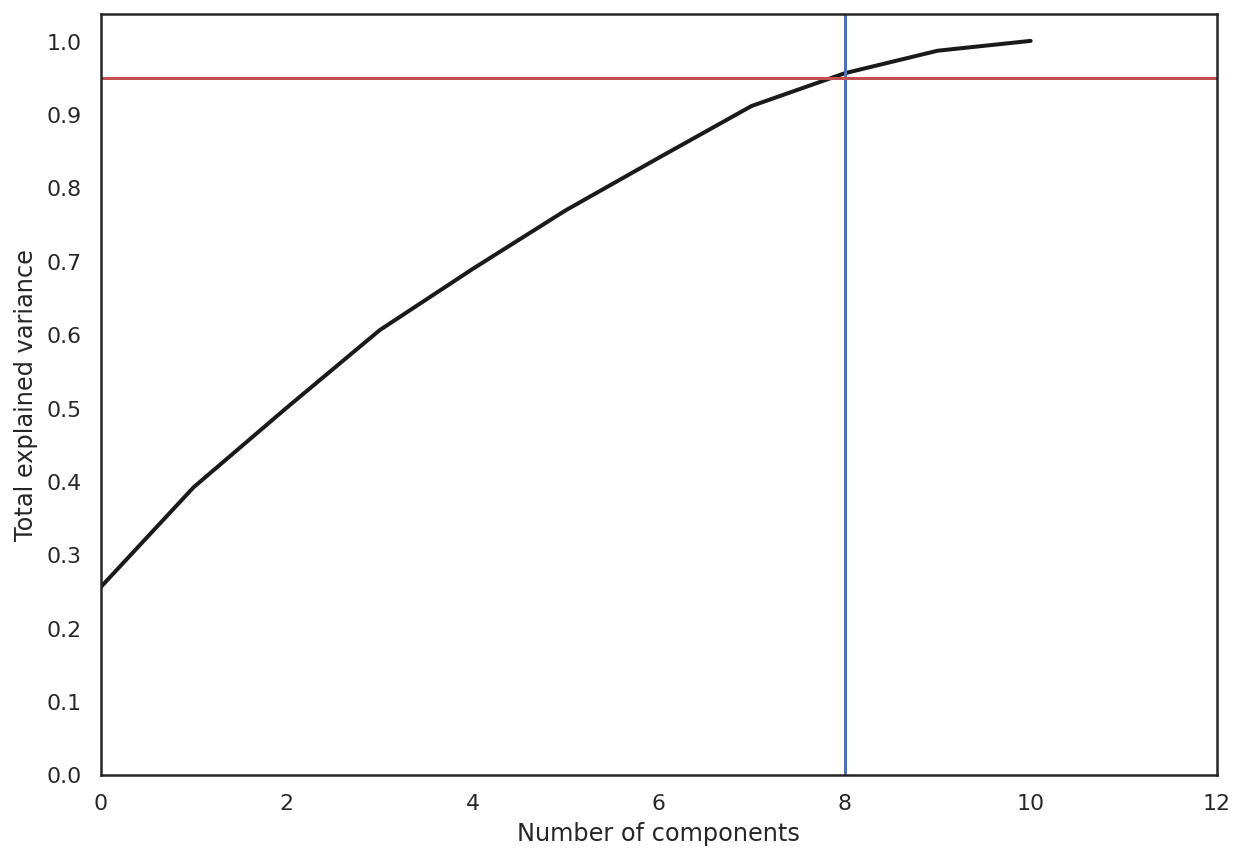

In [22]:
# Plotting the graph with total explained variance values in PCA for different number of components
# Setting 0.95 as the threshold value

pca = PCA().fit(X_train_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k',lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0,12)
plt.yticks(np.arange(0,1.1,0.1))
plt.axvline(8,c='b')
plt.axhline(0.95,c='r')
plt.show();

It is observed that for 8 components, the variance value is near 95%. Hence, we will be using 8 as the component count.

In [24]:
# Performing dimensionality reduction of the dataset using PCA

pca = PCA(n_components=8, random_state=42)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.fit_transform(X_test_scaled)

In [25]:
# Initializing the StratifiedKFold with 2 splits to perform GridSearch

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

### K Neighbors Classifier

In [26]:
# Performing GridSearch on KNeighborsClassifier to obtain best score using different parameters

knn_params = {'n_neighbors':range(1,11)}

knn = KNeighborsClassifier(n_jobs=-1)

knn_grid= GridSearchCV(knn,knn_params,cv=skf,n_jobs =-1,verbose=True)

knn_grid.fit(X_train_scaled,y_train)

print("Score:", knn_grid.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.5s finished


Score: 0.052408044456205345


### Random Forest Classifier

In [27]:
# Performing GridSearch on Random Forest Classifier to obtain best score using different parameters

parameters = {'max_features':[4],'min_samples_leaf':[1],'max_depth':[3]}

rfc = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)

forest_grid = GridSearchCV(rfc,parameters,n_jobs=-1,cv=skf,verbose=1)

forest_grid.fit(X_train_scaled,y_train)

print("Score:", forest_grid.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


Score: 0.04077798359354327


### Decision Tree Classifier

In [28]:
# Performing GridSearch on Decision Tree Classifier to obtain best score using different parameters

tree = DecisionTreeClassifier()

tree_params = {'max_depth':range(1,11),'max_features':range(4,19)}

tree_grid = GridSearchCV(tree,tree_params,cv=skf,n_jobs=-1,verbose=True)

tree_grid.fit(X_train_scaled, y_train)

print("Score:", tree_grid.best_score_)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 297 out of 300 | elapsed:  2.0min remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Score: 0.053320984387404076


### Voting Classifier

In [29]:
# Using Voting Classifier to get the best classifier for the given dataset
est = [
        ('knn1', KNeighborsClassifier(n_neighbors=10)),  
        ('rfc1', RandomForestClassifier(n_estimators=20)),
        ('ada1', AdaBoostClassifier(n_estimators=100)),
        ('ada2', AdaBoostClassifier(n_estimators=1000))
      ];

est_weights = [
               3   # weight for knn1
               1,   # weight for rfc1
               2  # weight for ada1
               1    # weight for ada2
               ];
    
voting = VotingClassifier(estimators=est, voting='soft', weights=est_weights)

# The returned voting classifier is trained with the training dataset and predictions are made on the validation set.
voting.fit(X_train_scaled, y_train);
y_pred   = voting.predict(X_test_scaled);

print("F1 Score: " + str(f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))))

F1 Score: 0.03105381469397863


## Classification of Genre values using Decision Tree Classifier

Based on the comparative analysis of different Classifier best score values, it is observed that Decision Tree Classifier score is slightly higher than the other classifiers. Hence, using Decision Tree Classifier to predict the genre values to the validation dataset.

In [30]:
# Picking the best estimator of Decision Tree Classifier obtained from the Grid Search and training the model

classifier = tree_grid.best_estimator_

classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
# Predicting the genre label values for the validation set

y_pred = classifier.predict(X_test_scaled)

In [33]:
# Displaying the records of the predicted labels

y_pred

array([  5, 159,  41, ..., 282, 234, 476])

In [35]:
# Computing the RMSE score between actual labels and predicted labels

mse = mean_squared_error(y_test, y_pred)
print("RMSE:", math.sqrt(mse))

RMSE: 24.069110029388632


In [37]:
# Computing the F1 score between actual labels and predicted labels

f1score = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print("F1 Score:", f1score)

F1 Score: 0.3376361968718211


# Clustering

The given dataset is first normalized using StandardScaler normalization and then clustered using couple of Clustering algorithms. The clustering algorithms used are K-Means Clustering and DBSCAN Clustering.

The performance of the clustering algorithms is evaluated using two score functions. They are:
*   Silhouette Score
*   Calinski & Harabasz Score




In [39]:
# Dropping the unnecessary columns for clustering

data_to_cluster = df.drop(columns=['ID', 'Genre_ID', 'Name'])

In [40]:
# Normalizing the dataset by removing mean and scaling it to unit variance using StandardScaler transformation
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

stdScaler = StandardScaler()
data_to_cluster_scaled = stdScaler.fit_transform(data_to_cluster)

In [41]:
# Performing dimensionality reduction using PCA 

pca = PCA(n_components=8, random_state=42)
data_to_cluster_scaled = pca.fit_transform(data_to_cluster_scaled)

### K-Means Clustering

K-Means Clustering

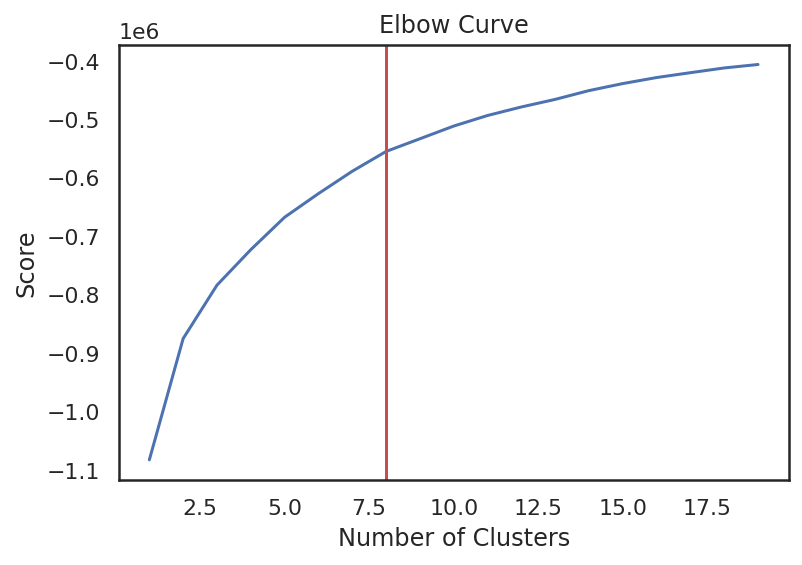

In [44]:
# Building a K-Means Clustering model for different values of K and computing the score for each K and plotting an Elbow curve
# Reference: https://www.kaggle.com/yugagrawal95/k-means-clustering-using-seaborn-visualization

kmeans = [KMeans(n_clusters=i) for i in range(1,20)]
score = [kmeans[i].fit(data_to_cluster_scaled).score(data_to_cluster_scaled) for i in range(len(kmeans))]
plt.plot(range(1,20), score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.axvline(8,c='r')
plt.title('Elbow Curve')
plt.show()

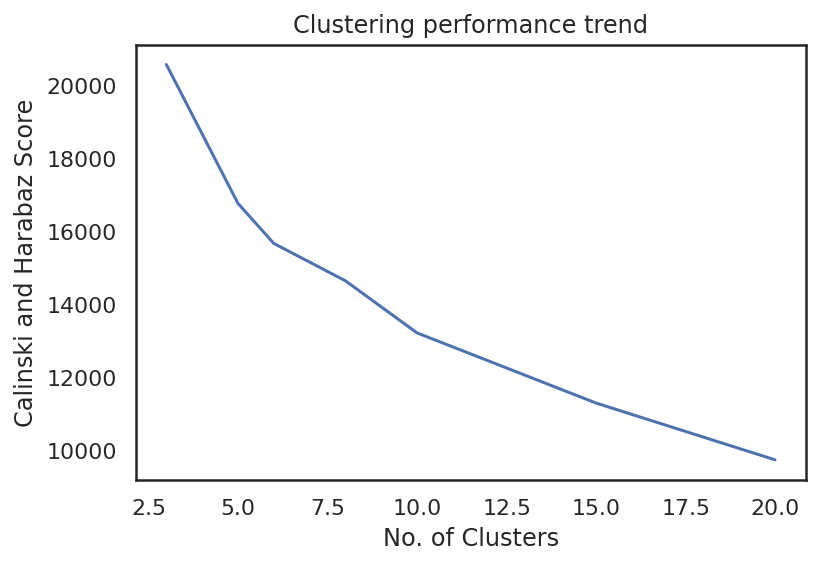

In [49]:
# Building a K-Means Clustering model for different values of K and computing the CH score for each K
num_clusters = [3,5,6,8,10,15,20]
CHscores    = []

for k in num_clusters:
    kmeans = KMeans(n_clusters = k, random_state = 300).fit(data_to_cluster_scaled)
    score = calinski_harabasz_score(data_to_cluster_scaled, kmeans.labels_)
    CHscores.append(score)

# Plotting a graph between different K values and their respective CH scores
plt.plot(num_clusters, CHscores)
plt.xlabel('No. of Clusters')
plt.ylabel('Calinski and Harabaz Score')
plt.title('Clustering performance trend')
plt.show()

In [50]:
# Initializing the K-Means Clustering model using the number of clusters decided above and fitting the data into it

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(data_to_cluster_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [51]:
# Fetching the predicted label values based on DBSCAN Clustering

predicted_labels = kmeans.labels_

In [52]:
# Computing the Silhouette Score for the predicted labels using K-Means clustering

silscore = silhouette_score(data_to_cluster_scaled, predicted_labels)
print("Silhouette Score: ", silscore)

Silhouette Score:  0.15028273483601293


In [53]:
# Computing the CH Score for the predicted labels using K-Means clustering

chscore = calinski_harabasz_score(data_to_cluster_scaled, predicted_labels)
print("CH Score: ", chscore)

CH Score:  14657.659758039264


### DBSCAN Clustering

DBSCAN Clustering

In [54]:
# Initializing the DBSCAN Clustering model and fitting the data into it

dbsc = DBSCAN(eps = .5, min_samples = 15)
dbsc.fit(data_to_cluster_scaled)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [55]:
# Fetching the predicted label values based on DBSCAN Clustering

predicted_labels = dbsc.labels_

In [56]:
# Computing the Silhouette Score for the predicted labels using DBSCAN clustering

silscore = silhouette_score(data_to_cluster_scaled, predicted_labels)
print("Silhouette Score: ", silscore)

Silhouette Score:  -0.47909102650339874


In [57]:
# Computing the CH Score for the predicted labels using DBSCAN clustering

chscore = calinski_harabasz_score(data_to_cluster_scaled, predicted_labels)
print("CH Score: ", chscore)

CH Score:  182.7865292948982


### Mapping K-Means Clustering Results

Based on the comparative analysis of Silhouette score and Calinski Harabasz score, it shows that K-Means Clustering has more accuracy and appropriate for this dataset. Hence using the Cluster labels from K-Means clustering to assign them to songs in the dataframe.

In [58]:
# Assigning the predicted labels from K-Means Clustering to the songs

predicted_labels = kmeans.labels_
df['Cluster'] = predicted_labels

In [59]:
# Displaying the number of clusters

print("Clusters:", len(np.unique(df['Cluster'])))

Clusters: 8


In [60]:
# Displaying the count of songs in each cluster

df['Cluster'].value_counts()

1    22651
4    19302
7    16931
0    15305
2    14940
5     8796
3     5973
6     4074
Name: Cluster, dtype: int64

This shows that the songs are assigned with a Cluster label after the clustering and how many songs are present in each cluster.

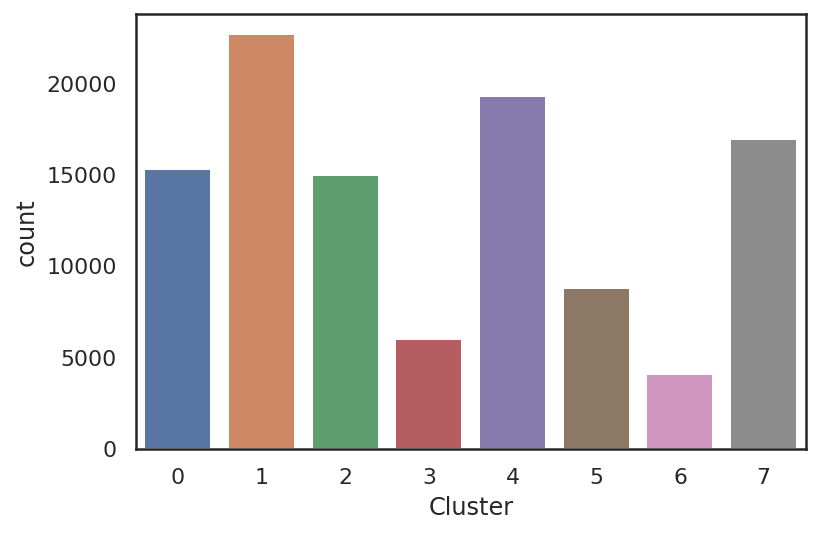

In [61]:
# Plotting the count of songs in each cluster on bar graph to visualize the song distribution in clusters
# Reference: https://seaborn.pydata.org/generated/seaborn.countplot.html

sns.countplot(data=df, x='Cluster', label='Count')

The above bar graph depicts the distribution of songs in different clusters.

# Recommendation System

This section consists of the functions which takes the songs from users playlist as parameter and returns the most similar songs based on their cosine similarity values

In [62]:
# Function to fetch the similar songs to a given song from the songs present in the cluster the given song is in
# This function calculates the cosine similarity of all the songs in the cluster with given song and picks the songs with high cosine similarity value
# All the songs are sorted and filtered for top 5 songs based on their cosine similarity and rating values are calculated based on the given song's rating

def getSimilarSongsForGivenSongFromCluster(song_id, rating):

  no_of_songs = 5

  # Filtering the dataset to fetch the songs from the same cluster as the given song
  given_song = df[df['ID'] == song_id] 
  cluster_id = given_song.Cluster.item()
  cluster_songs = df[df['Cluster'] == cluster_id]

  # Formatting the current song value into array
  current_song = given_song.drop(['Name', 'ID', 'Cluster'], axis=1)
  current_song = current_song.values.tolist() 

  # Formatting the cluster songs value into array
  cluster_songs_list = cluster_songs.drop(['Name', 'ID', 'Cluster'], axis=1)
  cluster_songs_list = cluster_songs_list.values.tolist()

  # Computing the COSINE SIMILARITY values
  cosine_sim = cosine_similarity(current_song, cluster_songs_list)[0]

  # Mapping the cosine similarity values with each song
  song_similarity_map = pd.DataFrame()
  song_similarity_map['Name'] = cluster_songs['Name']
  song_similarity_map['song_id'] = cluster_songs['ID']
  song_similarity_map['similarity'] = cosine_sim

  # Removing the current song from similar songs list
  song_similarity_map = song_similarity_map[song_similarity_map['song_id'] != song_id]

  # Sorting the songs based on similarity values in Descending order
  song_similarity_map = song_similarity_map.sort_values(by=['similarity'], ascending=False)

  most_similar_songs = song_similarity_map[:no_of_songs]
  most_similar_songs.insert(1,'Rating',0)

  # Calculating the rating value of each song by multiplying current song rating with cosine similarity value
  for index, row in most_similar_songs.iterrows(): 
    most_similar_songs.loc[index, "Rating"] = rating * row['similarity']

  most_similar_songs = most_similar_songs.drop(['similarity'], axis = 1)

  return most_similar_songs

In [63]:
# Function to fetch the similar songs to a given song from complete set of songs in the database
# This function calculates the cosine similarity of all the songs with given song and picks the songs with high cosine similarity value
# All the songs are sorted and filtered for top 5 songs based on their cosine similarity and rating values are calculated based on the given song's rating

def getSimilarSongsForGivenSongFromWholeDataSet(song_id, rating):

  no_of_songs = 5

  # Fetching the current song from dataset based on song_id
  given_song = df[df['ID'] == song_id] 
  all_songs = df.copy()

  # Formatting the current song value into array
  current_song = given_song.drop(['Name', 'ID', 'Cluster'], axis=1)
  current_song = current_song.values.tolist() 

  # Formatting all the songs value into array
  all_songs_list = all_songs.drop(['Name', 'ID', 'Cluster'], axis=1)
  all_songs_list = all_songs_list.values.tolist()

  # Computing the COSINE SIMILARITY values
  cosine_sim = cosine_similarity(current_song, all_songs_list)[0]

  # Mapping the cosine similarity values with each song
  song_similarity_map = pd.DataFrame()
  song_similarity_map['Name'] = all_songs['Name']
  song_similarity_map['song_id'] = all_songs['ID']
  song_similarity_map['similarity'] = cosine_sim

  # Removing the current song from similar songs list
  song_similarity_map = song_similarity_map[song_similarity_map['song_id'] != song_id]

  # Sorting the songs based on similarity values in Descending order
  song_similarity_map = song_similarity_map.sort_values(by=['similarity'], ascending=False)

  most_similar_songs = song_similarity_map[:no_of_songs]
  most_similar_songs.insert(1,'Rating',0)

  # Calculating the rating value of each song by multiplying current song rating with cosine similarity value
  for index, row in most_similar_songs.iterrows(): 
    most_similar_songs.loc[index, "Rating"] = rating * row['similarity']

  most_similar_songs = most_similar_songs.drop(['similarity'], axis = 1)

  return most_similar_songs

In [64]:
# Function to fetch the most similar songs to the songs in a given playlist from cluster of songs the song is in
# This function iterates over each song and fetches the most similar songs to it
# All the recommended songs are sorted and filtered for top 5 based on their rating 

def getSimilarSongRecommendationsFromCluster(user_playlist):

  song_ids = []
  song_id_and_ratings = []

  # Iterating over each song in the playlist
  for song in user_playlist:
    index = df.index[df['Name'] == song[0]]

    # Checking if the given song is present in the song database
    if len(index) == 0:
      print(song[0] + " is not found in the Song Database")
      return
    else:
      index = index[0].item()
      song_id_and_ratings.append([df['ID'][index].item(), song[1]])
      song_ids.append(df['ID'][index].item())
      

  similar_songs = pd.DataFrame(columns=['song_id', 'Name', 'Rating'])

  # Iterating over each song in the playlist  
  for song_id, rating in song_id_and_ratings:
    # Fetching content based similar songs for each song from the cluster the song is in
    similar_songs = pd.concat([similar_songs, getSimilarSongsForGivenSongFromCluster(song_id, rating)])

  # Checking if the recommended songs are not already in the given playlist
  similar_songs = similar_songs[~similar_songs.song_id.isin(song_ids)]

  # Sorting the songs based on the predicted rating values and picking only top most songs
  similar_songs = similar_songs.sort_values(by=['Rating'], ascending=False)[:5]

  similar_songs = similar_songs.drop(['song_id'], axis=1)

  return similar_songs
    

In [75]:
# Function to fetch the most similar songs to the songs in a given playlist from complete collection of songs
# This function iterates over each song and fetches the most similar songs to it
# All the recommended songs are sorted and filtered for top 5 based on their rating 

def getSimilarSongRecommendations(user_playlist):

  no_of_rec_songs = 5

  song_ids = []
  song_id_and_ratings = []

  # Iterating over each song in the playlist
  for song in user_playlist:
    index = df.index[df['Name'] == song[0]]

    # Checking if the given song is present in the song database
    if len(index) == 0:
      print(song[0] + " is not found in the Song Database")
      return
    else:
      index = index[0].item()
      song_id_and_ratings.append([df['ID'][index].item(), song[1]])
      song_ids.append(df['ID'][index].item())
      
  similar_songs = pd.DataFrame(columns=['song_id', 'Name', 'Rating'])

  # Iterating over each song in the playlist
  for song_id, rating in song_id_and_ratings:
    # Fetching content based similar songs for each song
    similar_songs = pd.concat([similar_songs, getSimilarSongsForGivenSongFromWholeDataSet(song_id, rating)])

  # Checking if the recommended songs are not already in the given playlist
  similar_songs = similar_songs[~similar_songs.song_id.isin(song_ids)]

  # Sorting the songs based on the predicted rating values and picking only top most songs
  similar_songs = similar_songs.sort_values(by=['Rating'], ascending=False)[:no_of_rec_songs]

  similar_songs = similar_songs.drop(['song_id'], axis=1)

  return similar_songs

# User Interface

In this section, we are simulating an User Interface where the User can enter all the songs in his playlist and provide ratings to those songs. Based on the songs added by the user into his playlist, song recommendations are provided to the user by fetching the top 5 most similar songs based on the content by generating cosine_similarity values for all the songs with the given song. The user provided rating values are used to calculate the ratings to the recommended songs by multiplying them with the cosine_similarity value.

In [66]:
# Function to accept inputs from user
# User needs to enter the number of songs in the playlist, followed by the Song name and the rating to that song

def getUserPlaylist():
  count = input("Enter the number of songs in your playlist:")

  playlist = []
  for i in range(int(count)):
    song = []
    song_name = input("Enter the name of the song:")
    rating = input("Enter the rating value for this song on the scale of 1 to 10:")
    song.append(song_name)
    song.append(int(rating))
    playlist.append(song) 

In [67]:
# Initial dummy values for User's playlist for testing

playlist = [
            ['YuveYuveYu', 9], 
            ['Gloryhammer', 8],
            ['Animal', 7],
            ['Promises', 9],
            ['SlayerofKings', 8],
            ]

In [77]:
#@title User Playlist Input Form
# Function call to accept input for User's Playslist

getUserPlaylist()

Enter the number of songs in your playlist:6
Enter the name of the song:RiseofaHero
Enter the rating value for this song on the scale of 1 to 10:9
Enter the name of the song:SpillBloodOnFire
Enter the rating value for this song on the scale of 1 to 10:10
Enter the name of the song:FallofMonsegur
Enter the rating value for this song on the scale of 1 to 10:8
Enter the name of the song:BringUsPintsOfBeer
Enter the rating value for this song on the scale of 1 to 10:7
Enter the name of the song:BloodstainedGround
Enter the rating value for this song on the scale of 1 to 10:8
Enter the name of the song:LongnecksandRednecks
Enter the rating value for this song on the scale of 1 to 10:9


In [78]:
# Function call to fetch a playlist recommendation based on given playlist by considering all the songs in the Song Database

getSimilarSongRecommendations(playlist)

,Name,Rating
71443,BringMeLove,8.999833
322,ElaRoubouMeuCaminhão,8.999830
74621,TheRevisionist,8.999808
56995,LoyaltyBeforeRoyalty,8.999799
373,RidingtheStorm,8.999724


In [79]:
# Function call to fetch a playlist recommendation based on given playlist by considering the songs in the Clusters the given songs are in

getSimilarSongRecommendationsFromCluster(playlist)

,Name,Rating
103286,VirginBirds,8.999674
27581,FallenAngel,8.999641
5108,PicturingLove,8.999634
107604,SoulRun,8.999617
71489,Kush&Corinthians,8.999606
